In [2]:
import feather
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [173]:
train = feather.read_dataframe('../data/interim/train.ftr')
test = feather.read_dataframe('../data/interim/test.ftr')

train['totals.transactionRevenue'] = train['totals.transactionRevenue'].astype(float)
train['totals.transactionRevenue_log'] = train['totals.transactionRevenue'].apply(lambda x: np.log(x) if x==x else 0)
train['date'] = pd.to_datetime(train['date'], format='%Y%m%d')
test['date'] = pd.to_datetime(test['date'], format='%Y%m%d')

train.shape, test.shape

((903653, 56), (804684, 53))

In [3]:
print('Number of unique visitor in train set:', train["fullVisitorId"].nunique(), \
      'out of rows:', len(train), \
      'and ratio is:', train['fullVisitorId'].nunique()/len(train))

print('Number of unique visitor in test set:', test["fullVisitorId"].nunique(), \
      'out of rows:', len(test), \
      'and ratio is:', test['fullVisitorId'].nunique()/len(test))

id_train_test = set(train.fullVisitorId.unique()).intersection(set(test.fullVisitorId.unique()))
print("Number of common visitors in train and test set:", len(id_train_test))

Number of unique visitor in train set: 714167 out of rows: 903653 and ratio is: 0.7903111039303804
Number of unique visitor in test set: 617242 out of rows: 804684 and ratio is: 0.7670613557620134
Number of common visitors in train and test set: 7679


### 登場回数に関して調査

2回以上登場しているidの割合を調査
- train, testともに、おおよそ14%の割合で重複が発生している。

In [4]:
summary_id_train = train.groupby('fullVisitorId').count()['date']
summary_id_train.name = 'train'
summary_id_test = test.groupby('fullVisitorId').count()['date']
summary_id_test.name = 'test'
concat_data = pd.concat([summary_id_train, summary_id_test], axis=1, sort=True).fillna(0)

print('train:', len(concat_data.query('train>1')), "/" ,len(concat_data.query('train>=1')), 'and ratio is:', len(concat_data.query('train>1'))/len(concat_data.query('train>=1')))
print('test:', len(concat_data.query('test>1')), "/" ,len(concat_data.query('test>=1')), 'and ratio is:', len(concat_data.query('test>1'))/len(concat_data.query('test>=1')))

train: 93492 / 714167 and ratio is: 0.130910557334629
test: 91418 / 617242 and ratio is: 0.14810722536703594


revenueがNULLかどうかが、登場回数に影響しているか

In [5]:
# id毎にrevenueをまとめる。
revenue_per_id = train.groupby('fullVisitorId').sum()['totals.transactionRevenue']
concat_data = pd.concat([concat_data, revenue_per_id], axis=1, sort=True).fillna(0)
concat_data['revenue_null_flg'] = (concat_data['totals.transactionRevenue'] == 0).astype(int)
concat_data['totals.transactionRevenue_log'] = concat_data['totals.transactionRevenue'].apply(lambda x: np.log(x) if x!=0 else 0)

- 登場回数が多いほど、購入するIDの比率が多くなる。

revenue_null_flg,0,1,ratio
train,,,
1.0,3120.0,617555.0,0.005027
2.0,2258.0,56453.0,0.038460
3.0,1468.0,15691.0,0.085553
4.0,938.0,6462.0,0.126757
5.0,611.0,3022.0,0.168181
6.0,414.0,1651.0,0.200484
7.0,278.0,953.0,0.225833
8.0,218.0,620.0,0.260143
9.0,142.0,396.0,0.263941


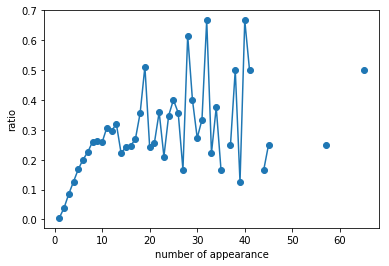

In [10]:
result = concat_data.query('train>0').groupby(['train', 'revenue_null_flg']).count()['test'].unstack()
result['ratio'] = result[0] / (result[0]+result[1])
display(result.head(10))

plt.plot(result.index, result.ratio, 'o-')
plt.xlabel('number of appearance')
plt.ylabel('ratio')
plt.show()

登場回数が多いIDについて
- 全てbotというわけではない。

In [11]:
concat_data.query('train>100')

,train,test,totals.transactionRevenue,revenue_null_flg,totals.transactionRevenue_log
0232377434237234751,135.0,32.0,1.798000e+07,0,16.704771
0720311197761340948,153.0,27.0,0.000000e+00,1,0.000000
0824839726118485274,255.0,3.0,0.000000e+00,1,0.000000
0949718915643445721,128.0,0.0,0.000000e+00,1,0.000000
1856749147915772585,199.0,0.0,0.000000e+00,1,0.000000
1957458976293878100,278.0,122.0,7.711343e+10,0,25.068543
2194592743396253647,107.0,0.0,2.493000e+07,0,17.031582
3148617623907142276,112.0,0.0,0.000000e+00,1,0.000000
3269834865385146569,155.0,2.0,1.799000e+08,0,19.007912
3525537916960843419,115.0,11.0,0.000000e+00,1,0.000000


In [12]:
# train=0の時のrevenueは実際の値でないことに注意
concat_data.query('test>100')

,train,test,totals.transactionRevenue,revenue_null_flg,totals.transactionRevenue_log
0348420048060754000,0.0,177.0,0.000000e+00,1,0.000000
0603203541488487946,0.0,148.0,0.000000e+00,1,0.000000
0827807801897731454,0.0,127.0,0.000000e+00,1,0.000000
1322101426801959631,0.0,153.0,0.000000e+00,1,0.000000
1957458976293878100,278.0,122.0,7.711343e+10,0,25.068543
3884810646891698298,27.0,241.0,0.000000e+00,1,0.000000
460252456180441002,0.0,162.0,0.000000e+00,1,0.000000
5211936831694160345,0.0,120.0,0.000000e+00,1,0.000000
603935369785924594,0.0,101.0,0.000000e+00,1,0.000000
705991343467703841,0.0,119.0,0.000000e+00,1,0.000000


trainとtestの両方に出現するIDについて調査

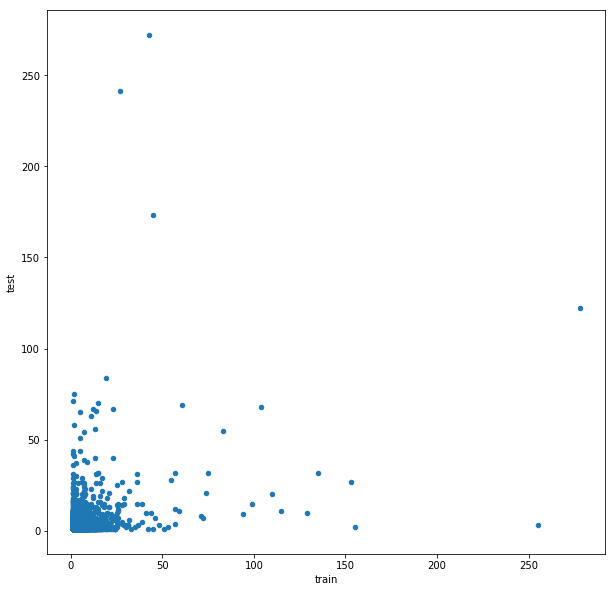

In [13]:
concat_data.query('train>0 & test>0').plot.scatter(x='train', y='test', figsize=(10, 10))
plt.show()

- 登場回数とrevenueの相関

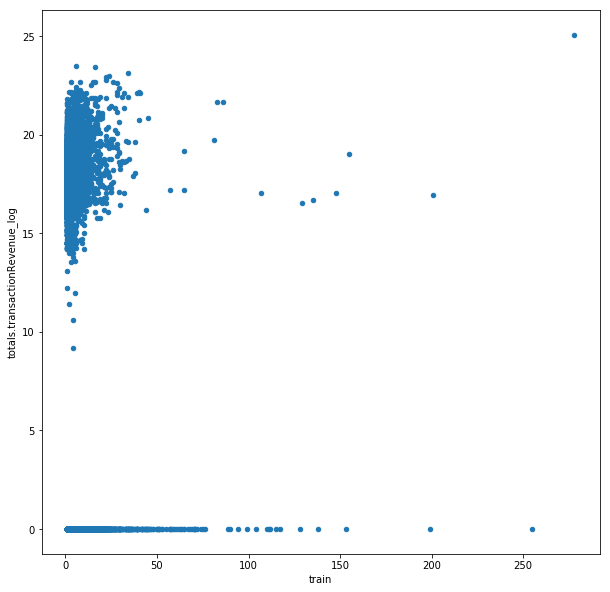

In [14]:
concat_data.query('train>0').plot.scatter(x='train', y='totals.transactionRevenue_log', figsize=(10, 10))

### 特徴量作成

過去n日間に何回サイトに訪れたか

In [174]:
total = pd.concat([train, test], axis=0, sort=False, ignore_index=True)
train_index = range(0, len(train))
test_index = range(len(train), len(train) + len(test))

total['visitStartTime'] = pd.to_datetime(total['visitStartTime'], unit='s')
total['visitId'] = pd.to_datetime(total['visitId'], unit='s')
total['date'] = pd.to_datetime(total['date'], format='%Y%m%d')

In [68]:
# 1回しか訪れていないIDの数を調べる。
# これらは集計時に思考停止で値を入力できる。
grp_result = total.groupby('fullVisitorId').size()
one_visitor_id = grp_result[grp_result==1].index.tolist()
more_one_visitor_id = grp_result[grp_result!=1].index.tolist()
len(one_visitor_id), len(more_one_visitor_id), len(grp_result), len(total)

(1138049, 185681, 1323730, 1708337)

In [151]:
# 複数回訪れているIDの中で、最も回数の多いもの
total.groupby('fullVisitorId').size().sort_values(ascending=False).head()

fullVisitorId
1957458976293878100    400
7282998257608986241    315
3884810646891698298    268
0824839726118485274    258
7477638593794484792    218
dtype: int64

In [160]:
n_days = - 30
total['threshold'] = total['visitStartTime'] + datetime.timedelta(days=n_days)
search_df = total[['fullVisitorId', 'visitStartTime', 'threshold']].copy()
search_df = search_df[search_df['fullVisitorId'].isin(more_one_visitor_id)]

test = search_df.sort_values(['fullVisitorId', 'visitStartTime'], ascending=[False, True])
test

,fullVisitorId,visitStartTime,threshold
1403334,9999985820452794361,2018-04-19 21:37:52,2018-03-20 21:37:52
1403255,9999985820452794361,2018-04-19 21:47:23,2018-03-20 21:47:23
796213,999997550040396460,2017-04-09 03:28:53,2017-03-10 03:28:53
812150,999997550040396460,2017-04-19 22:27:18,2017-03-20 22:27:18
1248896,9999824326944242344,2017-12-10 04:29:06,2017-11-10 04:29:06
1007421,9999824326944242344,2017-12-12 20:51:01,2017-11-12 20:51:01
1634563,9999819762744314978,2017-11-17 15:12:28,2017-10-18 15:12:28
1586528,9999819762744314978,2017-11-20 11:41:36,2017-10-21 11:41:36
1341038,9999819762744314978,2017-11-23 07:15:12,2017-10-24 07:15:12
1340661,9999819762744314978,2017-11-23 07:46:37,2017-10-24 07:46:37


In [141]:
for n_lag in tqdm(range(1, 400+1), ascii=False):
    col = f'lag_{n_lag}'
    test[col] = test.groupby('fullVisitorId')['visitStartTime'].shift(n_lag)
    test[col] = (test[col]>test['threshold']).astype(int)





  0%|          | 0/400 [00:00<?, ?it/s]



  0%|          | 1/400 [00:00<05:14,  1.27it/s]



  0%|          | 2/400 [00:01<05:14,  1.27it/s]



  1%|          | 3/400 [00:02<05:14,  1.26it/s]



  1%|          | 4/400 [00:03<05:11,  1.27it/s]



  1%|▏         | 5/400 [00:03<05:12,  1.26it/s]



  2%|▏         | 6/400 [00:04<05:12,  1.26it/s]



  2%|▏         | 7/400 [00:05<05:12,  1.26it/s]



  2%|▏         | 8/400 [00:06<05:10,  1.26it/s]



  2%|▏         | 9/400 [00:07<05:12,  1.25it/s]



  2%|▎         | 10/400 [00:07<05:12,  1.25it/s]



  3%|▎         | 11/400 [00:08<05:13,  1.24it/s]



  3%|▎         | 12/400 [00:09<05:15,  1.23it/s]



  3%|▎         | 13/400 [00:10<05:15,  1.23it/s]



  4%|▎         | 14/400 [00:11<05:13,  1.23it/s]



  4%|▍         | 15/400 [00:12<05:19,  1.21it/s]



  4%|▍         | 16/400 [00:12<05:21,  1.19it/s]



  4%|▍         | 17/400 [00:13<05:22,  1.19it/s]



  4%|▍         | 18/400 [00:14<05:21,  1.19it/s]



  5%|▍         | 19/400 [0

 32%|███▏      | 127/400 [02:09<05:39,  1.24s/it]



 32%|███▏      | 128/400 [02:10<05:38,  1.24s/it]



 32%|███▏      | 129/400 [02:11<05:38,  1.25s/it]



 32%|███▎      | 130/400 [02:12<05:36,  1.25s/it]



 33%|███▎      | 131/400 [02:14<05:34,  1.24s/it]



 33%|███▎      | 132/400 [02:15<05:33,  1.24s/it]



 33%|███▎      | 133/400 [02:16<05:35,  1.26s/it]



 34%|███▎      | 134/400 [02:17<05:35,  1.26s/it]



 34%|███▍      | 135/400 [02:19<05:35,  1.27s/it]



 34%|███▍      | 136/400 [02:20<05:36,  1.27s/it]



 34%|███▍      | 137/400 [02:21<05:37,  1.28s/it]



 34%|███▍      | 138/400 [02:23<05:36,  1.28s/it]



 35%|███▍      | 139/400 [02:24<05:35,  1.28s/it]



 35%|███▌      | 140/400 [02:25<05:35,  1.29s/it]



 35%|███▌      | 141/400 [02:27<05:36,  1.30s/it]



 36%|███▌      | 142/400 [02:28<05:36,  1.31s/it]



 36%|███▌      | 143/400 [02:29<05:35,  1.31s/it]



 36%|███▌      | 144/400 [02:31<05:35,  1.31s/it]



 36%|███▋      | 145/400 [02:32<05:36,  1.32s/

 63%|██████▎   | 253/400 [05:16<04:07,  1.69s/it]



 64%|██████▎   | 254/400 [05:18<04:08,  1.70s/it]



 64%|██████▍   | 255/400 [05:20<04:04,  1.69s/it]



 64%|██████▍   | 256/400 [05:21<04:03,  1.69s/it]



 64%|██████▍   | 257/400 [05:23<04:03,  1.70s/it]



 64%|██████▍   | 258/400 [05:25<04:01,  1.70s/it]



 65%|██████▍   | 259/400 [05:26<04:00,  1.70s/it]



 65%|██████▌   | 260/400 [05:28<03:58,  1.70s/it]



 65%|██████▌   | 261/400 [05:30<03:57,  1.71s/it]



 66%|██████▌   | 262/400 [05:32<03:55,  1.71s/it]



 66%|██████▌   | 263/400 [05:33<03:55,  1.72s/it]



 66%|██████▌   | 264/400 [05:35<03:54,  1.72s/it]



 66%|██████▋   | 265/400 [05:37<03:53,  1.73s/it]



 66%|██████▋   | 266/400 [05:39<03:52,  1.74s/it]



 67%|██████▋   | 267/400 [05:40<03:52,  1.75s/it]



 67%|██████▋   | 268/400 [05:42<03:52,  1.76s/it]



 67%|██████▋   | 269/400 [05:44<03:49,  1.75s/it]



 68%|██████▊   | 270/400 [05:46<03:47,  1.75s/it]



 68%|██████▊   | 271/400 [05:47<03:46,  1.76s/

 95%|█████████▍| 379/400 [09:18<00:44,  2.12s/it]



 95%|█████████▌| 380/400 [09:20<00:42,  2.11s/it]



 95%|█████████▌| 381/400 [09:22<00:40,  2.13s/it]



 96%|█████████▌| 382/400 [09:24<00:38,  2.14s/it]



 96%|█████████▌| 383/400 [09:26<00:36,  2.14s/it]



 96%|█████████▌| 384/400 [09:28<00:34,  2.14s/it]



 96%|█████████▋| 385/400 [09:30<00:31,  2.13s/it]



 96%|█████████▋| 386/400 [09:33<00:29,  2.13s/it]



 97%|█████████▋| 387/400 [09:35<00:27,  2.13s/it]



 97%|█████████▋| 388/400 [09:37<00:25,  2.14s/it]



 97%|█████████▋| 389/400 [09:39<00:23,  2.15s/it]



 98%|█████████▊| 390/400 [09:41<00:21,  2.15s/it]



 98%|█████████▊| 391/400 [09:43<00:19,  2.16s/it]



 98%|█████████▊| 392/400 [09:46<00:17,  2.17s/it]



 98%|█████████▊| 393/400 [09:48<00:15,  2.17s/it]



 98%|█████████▊| 394/400 [09:50<00:12,  2.15s/it]



 99%|█████████▉| 395/400 [09:52<00:10,  2.15s/it]



 99%|█████████▉| 396/400 [09:54<00:08,  2.17s/it]



 99%|█████████▉| 397/400 [09:56<00:06,  2.17s/

### 特徴量（visitNumberの修正）

In [209]:
total = pd.concat([train, test], axis=0, sort=False, ignore_index=True)
train_index = range(0, len(train))
test_index = range(len(train), len(train) + len(test))
total['visitStartTime'] = pd.to_datetime(total['visitStartTime'], unit='s')

In [210]:
total = total.sort_values(['fullVisitorId', 'visitStartTime'], ascending=[False, True])
total[['fullVisitorId', 'visitStartTime', 'visitNumber']]

,fullVisitorId,visitStartTime,visitNumber
1358227,9999997304197521748,2017-10-14 18:02:10,1
141497,9999986437109498564,2017-04-10 23:41:10,1
1403334,9999985820452794361,2018-04-19 21:37:52,1
1403255,9999985820452794361,2018-04-19 21:47:23,2
617541,9999978264901065827,2017-01-25 06:26:20,1
796213,999997550040396460,2017-04-09 03:28:53,1
812150,999997550040396460,2017-04-19 22:27:18,2
182220,999997225970956660,2016-08-20 06:00:10,1
1154722,9999969142283897422,2018-02-26 13:36:56,1
413400,9999963186378918199,2017-03-13 14:49:06,1


In [268]:
total["test_value"] = 1
total["visitNumber_"] = total.groupby("fullVisitorId")["test_value"].cumsum()

In [249]:
result = total["visitNumber_"] - total["visitNumber"]
result[result!=0]

794989     -5
915673     -9
1616671   -12
1687656   -12
1567657    -9
991547     -2
1372288    -2
940213     -2
1591264    -2
1687197    -3
1087769    -5
1111593    -3
1312359    -3
1312195    -3
1532054    -9
1425007   -11
763467     -1
1574289    -1
225288     -1
359441     -1
359296     -1
538587     -1
122603     -1
469104     -1
653236     -1
351558     -2
1506774    -1
400289     -1
762539     -1
455777     -1
           ..
894479     -1
1425229    -1
1065832    -1
213356     -3
762279     -3
888594     -3
349134     -1
55590      -1
661061     -1
830236     -1
45004      -1
327386     -1
237308     -1
237480     -1
547425     -1
547416     -1
579095     -1
579111     -1
579118     -1
1555376    -2
1667561    -2
798973     -1
451101     -1
40028      -1
1073681    -1
973853     -2
951007      4
183359     -1
277698     -1
331550     -1
Length: 79468, dtype: int64

In [253]:
total[total['visitNumber'] != total['visitNumber_']]

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,totals.transactionRevenue_log,test_value,visitNumber_
794989,Referral,2016-12-14,9999136945887060446,9999136945887060446_1481740828,Not Socially Engaged,1481740828,7,2016-12-14 18:40:28,Chrome,not available in demo dataset,...,(not set),None,True,None,referral,/,mall.googleplex.com,0.000000,1,2
915673,Referral,2017-11-11,9999136945887060446,9999136945887060446_1510441163,Not Socially Engaged,1510441163,12,2017-11-11 22:59:23,Chrome,not available in demo dataset,...,(not set),NaN,True,None,referral,/,mall.googleplex.com,NaN,1,3
1616671,Referral,2018-01-23,9999136945887060446,9999136945887060446_1516775076,Not Socially Engaged,1516775076,16,2018-01-24 06:24:36,Chrome,not available in demo dataset,...,(not set),NaN,True,None,referral,/,mall.googleplex.com,NaN,1,4
1687656,Referral,2018-03-29,9999136945887060446,9999136945887060446_1522383373,Not Socially Engaged,1522383373,17,2018-03-30 04:16:13,Chrome,not available in demo dataset,...,(not set),NaN,True,None,referral,/,mall.googleplex.com,NaN,1,5
1567657,Referral,2017-11-16,9998461364191417784,9998461364191417784_1510898545,Not Socially Engaged,1510898545,10,2017-11-17 06:02:25,Chrome,not available in demo dataset,...,(not set),NaN,True,None,referral,/offer/2145,gdeals.googleplex.com,NaN,1,1
991547,Referral,2018-03-06,9998286704763161826,9998286704763161826_1520357361,Not Socially Engaged,1520357361,4,2018-03-06 17:29:21,Chrome,not available in demo dataset,...,(not set),NaN,True,None,referral,/,mall.googleplex.com,NaN,1,2
1372288,Referral,2018-03-14,9998286704763161826,9998286704763161826_1521063385,Not Socially Engaged,1521063385,5,2018-03-14 21:36:25,Chrome,not available in demo dataset,...,(not set),NaN,True,None,referral,/,mall.googleplex.com,NaN,1,3
940213,Referral,2018-03-16,9998286704763161826,9998286704763161826_1521217666,Not Socially Engaged,1521217666,6,2018-03-16 16:27:46,Chrome,not available in demo dataset,...,(not set),NaN,True,None,referral,/,mall.googleplex.com,NaN,1,4
1591264,Referral,2018-03-19,9998286704763161826,9998286704763161826_1521489216,Not Socially Engaged,1521489216,7,2018-03-19 19:53:36,Chrome,not available in demo dataset,...,(not set),NaN,True,None,referral,/,mall.googleplex.com,NaN,1,5
1687197,Referral,2018-03-29,9998286704763161826,9998286704763161826_1522355147,Not Socially Engaged,1522355147,9,2018-03-29 20:25:47,Chrome,not available in demo dataset,...,(not set),NaN,True,None,referral,/,mall.googleplex.com,NaN,1,6


In [289]:
result = total.groupby('fullVisitorId')['visitNumber'].min()
result.name = "geta"
result

fullVisitorId
0000000259678714014    1
0000010278554503158    1
0000020424342248747    1
0000027376579751715    1
0000039460501403861    1
0000040862739425590    1
0000049363351866189    1
000005103959234087     1
0000053049821714864    1
0000059488412965267    1
0000062267706107999    1
0000068403966359845    1
0000085059828173212    1
0000085840370633780    1
0000091131414287111    1
0000093957001069502    1
0000114156543135683    1
0000117255350596610    1
0000118334805178127    1
0000130646294093000    1
0000150005271820273    1
0000152474579038632    1
0000166374699289385    1
0000168159078983594    1
0000174067426171406    1
0000174453501096099    1
0000176652019531658    1
000018122977590134     1
0000197671390269035    1
000020731284570628     1
                      ..
999977536649351076     1
9999786007255502100    1
9999789814107288877    1
9999799804624735268    1
9999801229043043045    1
9999803502828528029    1
9999803509476553670    1
9999818112872622034    1
99998197627

In [292]:
merge_result = pd.merge(total, result.reset_index(), how="outer", on="fullVisitorId")

In [293]:
merge_result.loc[merge_result['fullVisitorId']=="9994817065147355333"]

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,totals.transactionRevenue_log,test_value,visitNumber_,geta
805,Organic Search,2016-10-20,9994817065147355333,9994817065147355333_1476967699,Not Socially Engaged,1476967699,21,2016-10-20 12:48:19,Chrome,not available in demo dataset,...,None,None,(not provided),organic,None,google,0.0,1,22,21
806,Referral,2016-10-27,9994817065147355333,9994817065147355333_1477567256,Not Socially Engaged,1477567256,22,2016-10-27 11:20:56,Chrome,not available in demo dataset,...,None,None,None,referral,/analytics/web/,analytics.google.com,0.0,1,23,21
807,Organic Search,2016-12-07,9994817065147355333,9994817065147355333_1481183691,Not Socially Engaged,1481183691,23,2016-12-08 07:54:51,Chrome,not available in demo dataset,...,None,None,(not provided),organic,None,google,0.0,1,24,21
808,Referral,2016-12-08,9994817065147355333,9994817065147355333_1481205695,Not Socially Engaged,1481205695,24,2016-12-08 14:01:35,Chrome,not available in demo dataset,...,None,None,None,referral,/analytics/web/,analytics.google.com,0.0,1,25,21
809,Organic Search,2017-03-15,9994817065147355333,9994817065147355333_1489643636,Not Socially Engaged,1489643636,25,2017-03-16 05:53:56,Chrome,not available in demo dataset,...,None,None,(not provided),organic,None,google,0.0,1,26,21
810,Referral,2017-03-16,9994817065147355333,9994817065147355333_1489669568,Not Socially Engaged,1489669568,26,2017-03-16 13:06:08,Chrome,not available in demo dataset,...,None,None,None,referral,/analytics/web/,analytics.google.com,0.0,1,27,21
811,Referral,2017-03-16,9994817065147355333,9994817065147355333_1489673063,Not Socially Engaged,1489673063,27,2017-03-16 14:04:23,Chrome,not available in demo dataset,...,None,True,None,referral,/analytics/web/,analytics.google.com,0.0,1,28,21
812,Organic Search,2017-04-10,9994817065147355333,9994817065147355333_1491891345,Not Socially Engaged,1491891345,28,2017-04-11 06:15:45,Chrome,not available in demo dataset,...,None,None,(not provided),organic,None,google,0.0,1,29,21
813,Organic Search,2017-07-25,9994817065147355333,9994817065147355333_1500990329,Not Socially Engaged,1500990329,29,2017-07-25 13:45:29,Chrome,not available in demo dataset,...,None,True,(not provided),organic,None,google,0.0,1,30,21
